In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    

%matplotlib inline


Bad key savefig.frameon in file c:\users\archi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file c:\users\archi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file c:\users\archi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [4]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [15]:
start_time = time.time()

augmented_data_path = 'D:\\archi\\6sem\\minor_project\\brain_tumor\\archive\\brain_tumor_dataset\\'
yes_path = "D:\\archi\\6sem\\minor_project\\brain_tumor\\archive\\brain_tumor_dataset\\yes\\"
no_path = "D:\\archi\\6sem\\minor_project\\brain_tumor\\archive\\brain_tumor_dataset\\no\\"
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:2:7.1


In [16]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [17]:
data_summary(augmented_data_path)

Number of examples: 2318
Percentage of positive examples: 53.49439171699741%, number of pos examples: 1240
Percentage of negative examples: 46.50560828300259%, number of neg examples: 1078


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [19]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

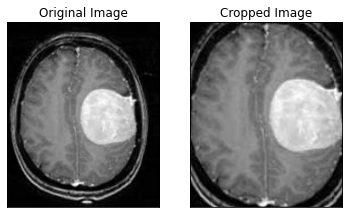

In [24]:
ex_img = cv2.imread('D:\\archi\\6sem\\minor_project\\brain_tumor\\archive\\brain_tumor_dataset\\yes\\aug_Y1_0_3023.jpg\\')
ex_new_img = crop_brain_contour(ex_img, True)

In [25]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [26]:
augmented_path = 'D:\\archi\\6sem\\minor_project\\brain_tumor\\archive\\brain_tumor_dataset\\'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2318
X shape is: (2318, 240, 240, 3)
y shape is: (2318, 1)


In [29]:
def plot_sample_images(X, y, n=10):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

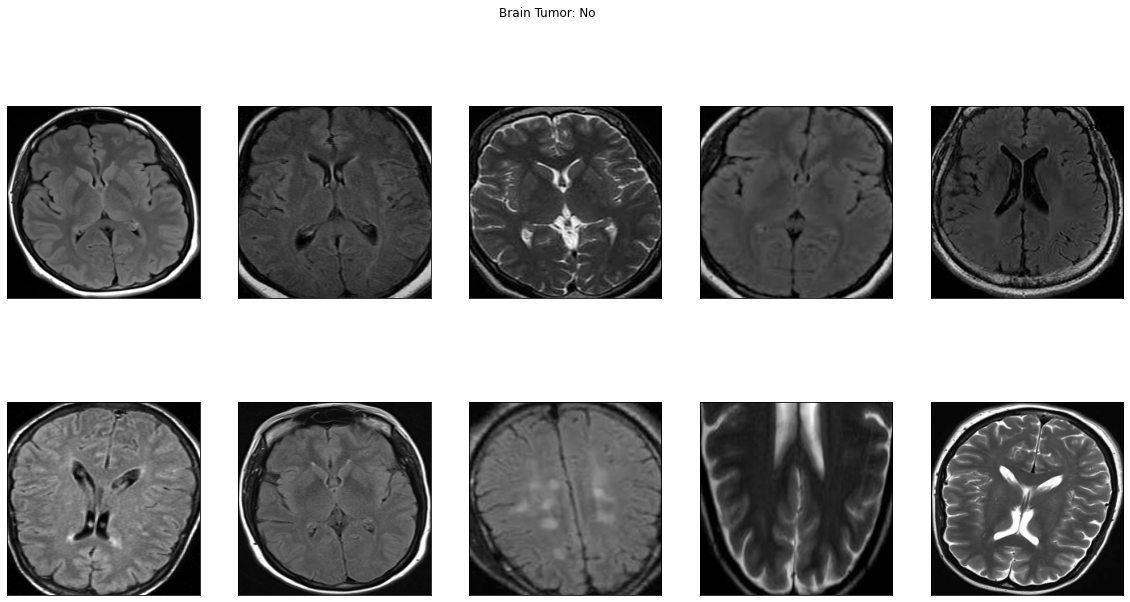

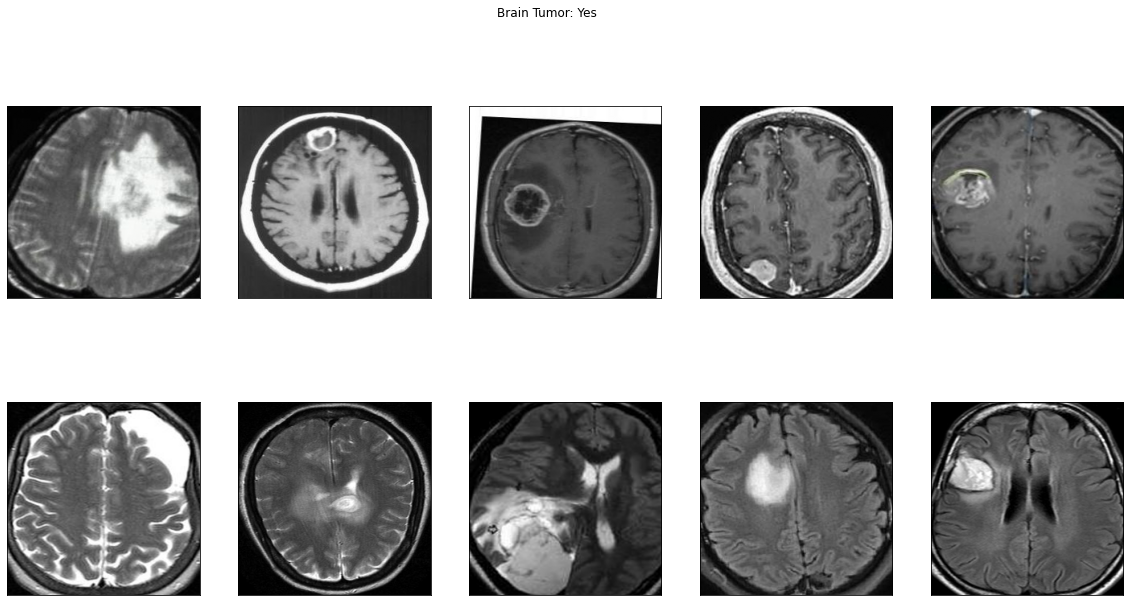

In [30]:
plot_sample_images(X, y)

In [31]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [33]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1622
number of development examples = 348
number of test examples = 348
X_train shape: (1622, 240, 240, 3)
Y_train shape: (1622, 1)
X_val (dev) shape: (348, 240, 240, 3)
Y_val (dev) shape: (348, 1)
X_test shape: (348, 240, 240, 3)
Y_test shape: (348, 1)


In [34]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [35]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [36]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs\\{log_file_name}')

In [52]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models\\{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [53]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1622 samples, validate on 348 samples
Epoch 1/10
1622/1622 [==============================] - 267s 165ms/sample - loss: 0.7388 - acc: 0.6492 - val_loss: 0.6209 - val_acc: 0.6609
Epoch 2/10
1622/1622 [==============================] - 250s 154ms/sample - loss: 0.5233 - acc: 0.7398 - val_loss: 0.5740 - val_acc: 0.7241
Epoch 3/10
1622/1622 [==============================] - 250s 154ms/sample - loss: 0.4131 - acc: 0.8083 - val_loss: 0.5372 - val_acc: 0.7787
Epoch 4/10
1622/1622 [==============================] - 249s 153ms/sample - loss: 0.3833 - acc: 0.8286 - val_loss: 0.4736 - val_acc: 0.8103
Epoch 5/10
1622/1622 [==============================] - 253s 156ms/sample - loss: 0.3362 - acc: 0.8656 - val_loss: 0.4547 - val_acc: 0.8046
Epoch 6/10
1622/1622 [==============================] - 247s 152ms/sample - loss: 0.2931 - acc: 0.8822 - val_loss: 0.4241 - val_acc: 0.8132
Epoch 7/10
1622/1622 [==============================] - 245s 151ms/sample - loss: 0.2748 - acc: 0.8903 - val_loss

In [54]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1622 samples, validate on 348 samples
Epoch 1/3
1622/1622 [==============================] - 293s 180ms/sample - loss: 0.2198 - acc: 0.9137 - val_loss: 0.4920 - val_acc: 0.7730
Epoch 2/3
1622/1622 [==============================] - 289s 178ms/sample - loss: 0.1903 - acc: 0.9371 - val_loss: 0.3402 - val_acc: 0.8649
Epoch 3/3
1622/1622 [==============================] - 278s 171ms/sample - loss: 0.1893 - acc: 0.9279 - val_loss: 0.3740 - val_acc: 0.8764
Elapsed time: 0:14:20.3


In [55]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1622 samples, validate on 348 samples
Epoch 1/3
1622/1622 [==============================] - 278s 172ms/sample - loss: 0.1977 - acc: 0.9199 - val_loss: 0.3458 - val_acc: 0.8822
Epoch 2/3
1622/1622 [==============================] - 278s 171ms/sample - loss: 0.2071 - acc: 0.9075 - val_loss: 0.4015 - val_acc: 0.8333
Epoch 3/3
1622/1622 [==============================] - 277s 171ms/sample - loss: 0.2138 - acc: 0.9020 - val_loss: 0.3554 - val_acc: 0.8621
Elapsed time: 0:13:53.9


In [56]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1622 samples, validate on 348 samples
Epoch 1/3
1622/1622 [==============================] - 277s 171ms/sample - loss: 0.1566 - acc: 0.9427 - val_loss: 0.3809 - val_acc: 0.8477
Epoch 2/3
1622/1622 [==============================] - 279s 172ms/sample - loss: 0.1270 - acc: 0.9550 - val_loss: 0.3325 - val_acc: 0.8822
Epoch 3/3
1622/1622 [==============================] - 280s 173ms/sample - loss: 0.1073 - acc: 0.9741 - val_loss: 0.3118 - val_acc: 0.9052
Elapsed time: 0:13:56.2


In [57]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1622 samples, validate on 348 samples
Epoch 1/5
1622/1622 [==============================] - 323s 199ms/sample - loss: 0.1035 - acc: 0.9741 - val_loss: 0.3554 - val_acc: 0.8563
Epoch 2/5
1622/1622 [==============================] - 258s 159ms/sample - loss: 0.0930 - acc: 0.9778 - val_loss: 0.3653 - val_acc: 0.8621
Epoch 3/5
1622/1622 [==============================] - 250s 154ms/sample - loss: 0.1028 - acc: 0.9723 - val_loss: 0.3127 - val_acc: 0.8994
Epoch 4/5
1622/1622 [==============================] - 248s 153ms/sample - loss: 0.0871 - acc: 0.9741 - val_loss: 0.5324 - val_acc: 0.8017
Epoch 5/5
1622/1622 [==============================] - 247s 152ms/sample - loss: 0.0936 - acc: 0.9710 - val_loss: 0.3232 - val_acc: 0.8937
Elapsed time: 0:22:6.0


In [58]:
history = model.history.history
for key in history.keys():
    print(key)

loss
acc
val_loss
val_acc


In [59]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

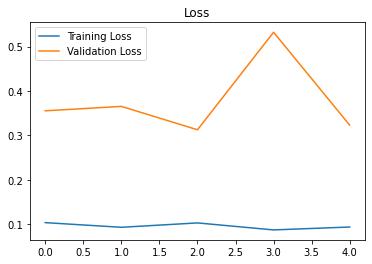

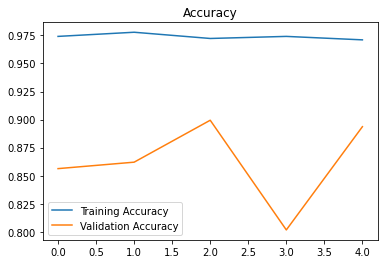

In [60]:
plot_metrics(history) 

In [95]:
best_model = load_model(filepath="D:\\archi\\6sem\\minor_project\\brain_tumor\\models\\cnn-parameters-improvement-03-0.90.model\\")
best_model.metrics_names

['loss', 'acc']

In [96]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

348/348 [==============================] - 3s 9ms/sample - loss: 0.2613 - acc: 0.9023


In [97]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.2613353494597577
Test Accuracy = 0.9022988677024841


In [98]:
y_test_prob = best_model.predict(X_test)


In [99]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9034090909090908


In [100]:
y_val_prob = best_model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9152542372881356


In [101]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 
# the whole data
data_percentage(y)

Number of examples: 2318
Percentage of positive examples: 53.49439171699741%, number of pos examples: 1240
Percentage of negative examples: 46.50560828300259%, number of neg examples: 1078


In [102]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1622
Percentage of positive examples: 53.51418002466091%, number of pos examples: 868
Percentage of negative examples: 46.48581997533909%, number of neg examples: 754
Validation Data:
Number of examples: 348
Percentage of positive examples: 58.62068965517241%, number of pos examples: 204
Percentage of negative examples: 41.37931034482759%, number of neg examples: 144
Testing Data:
Number of examples: 348
Percentage of positive examples: 48.275862068965516%, number of pos examples: 168
Percentage of negative examples: 51.724137931034484%, number of neg examples: 180
